# OC - Parcours Ingénieur IA - Projet 9 - BERKAN Asli Ceren

Une start-up, My Content, veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. On cherche à construire un premier "Minimum Viable Product" (MVP) sous forme d'application mobile. Pour ce faire, on va tester une solution de recommandations d'articles et de livres à des particuliers. On ne dispose pas de données, on va donc utiliser le jeu de données "News Portal User Interactions by Globo.com". Présentons rapidement le jeu de données. 

L'ensemble de données contient un échantillon d'interactions d'utilisateurs (pages vues) sur le portail d'actualités G1 du 1er au 16 octobre 2017, comprenant environ 3 millions de clics, répartis sur plus d'un million de sessions de la part de 314 000 utilisateurs qui ont lu plus de 46 000 articles d'actualité différents pendant cette période.

Il est composé de trois fichiers/dossiers : <br/>
clicks.zip : Dossier avec des fichiers CSV (un par heure), contenant les interactions des sessions utilisateur.
articles_metadata.csv : Fichier CSV avec des informations de métadonnées sur tous les (364047) articles publiés.
articles_embeddings.pickle : Pickle (Python 3) d'une matrice NumPy contenant les incorporations de contenu d'article (vecteurs de 250 dimensions), formées sur le texte et les métadonnées des articles par le module ACR de CHAMELEON pour 364047 articles publiés.

La fonctionnalité la plus critique pour lancer cette application mobile est la suivante : "En tant qu'utilisateur de l'application, je vais recevoir une sélection de cinq articles.". De plus, l'ajout de nouveaux utilisateurs et de nouveaux articles dans l'architecture cible est également déterminante. Un développeur web/mobile sera en charge de développer l'application mobile. Il met à notre disposition une première version simplifiée de l'application mobile pour tester notre système de recommandation.

Dans ce script, nous allons tester deux systèmes de recommandation : 
- Content-based recommender 
- Collaborative filtering
    - Avec la librairie "implicit"
    - Avec la librairie "surprise"

## Table of Contents

* [1. Analyse exploratoire](#chapter1)
* [2. Content-based recommeder](#chapter2)
* [3. Collaborative Filtering](#chapter3)
    * [3.1 Avec la librairie "implicit"](#section3_1)
    * [3.2 Avec la librairie "surprise"](#section3_2)

## 1. Analyse exploratoire <a class="anchor" id="chapter1"></a>

In [1]:
# Importer les librairies
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from csv import reader
import os
from scipy.spatial import distance
from random import randint
import implicit
from implicit.evaluation import precision_at_k, train_test_split
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sparse

In [2]:
# Charger articles_metadata
articles_metadata = pd.read_csv('Data/articles_metadata.csv')
print('Le jeu de données articles_metadata contient : ' +
      str(articles_metadata.shape[0]) + ' lignes et ' +
      str(articles_metadata.shape[1]) + ' colonnes.')
display(articles_metadata.head())

Le jeu de données articles_metadata contient : 364047 lignes et 5 colonnes.


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


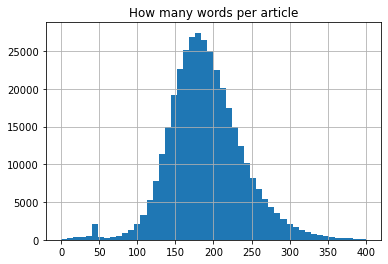

In [3]:
# Affichage nbr de mots par article
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

In [4]:
# Vérification du jeu de données articles_metadata
articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [5]:
# Vérification des valeurs null
articles_metadata.isnull().sum()

article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64

In [6]:
# Quelques stats
articles_metadata.describe(include='all')

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [7]:
# Nombre de valeurs uniques par colonnes
print(articles_metadata.nunique())

article_id       364047
category_id         461
created_at_ts    359552
publisher_id          1
words_count         866
dtype: int64


In [8]:
# Charger articles_embeddings
with open('Data/articles_embeddings.pickle', 'rb') as file_pi:
    articles_embeddings = pickle.load(file_pi)
print('Le jeu de données articles_embeddings contient : ' +
      str(articles_embeddings.shape[0]) + ' lignes et ' +
      str(articles_embeddings.shape[1]) + ' colonnes.')
display(articles_embeddings)

Le jeu de données articles_embeddings contient : 364047 lignes et 50 colonnes.


array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.62269634,
        -0.05000444,  0.42151213],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.40926453,
        -0.21786417,  0.49834716],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.70930463,
         0.5806534 , -0.5183282 ],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ...,  0.42565244,
        -0.47634116, -0.27730086],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.325031  ,
         0.44763875, -0.0881905 ],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.9167145 ,
         0.13803585,  0.96597433]], dtype=float32)

In [9]:
# # Charger les fichiers clicks
# files = os.listdir("Data/clicks")

# i = 0
# clicks = []
# for file in files :
#     path_file = "Data/clicks/" + file
#     temp = pd.read_csv(path_file) 
#     if i == 0 :
#         clicks = temp
#     else :
#         clicks = clicks.append(temp)
#     i = i + 1
    
# print('Le jeu de données clicks contient : ' +
#       str(clicks.shape[0]) + ' lignes et ' +
#       str(clicks.shape[1]) + ' colonnes.')
# display(clicks.head())

# # Save dataframe
# clicks.to_csv('Data/clicks_tot.csv', index=False)

In [10]:
# # Filtrer uniquement sur sur les user_id <= 10000
# clicks_reduced = clicks[clicks['user_id']<=10000]
# print('Le jeu de données clicks contient : ' +
#       str(clicks_reduced.shape[0]) + ' lignes et ' +
#       str(clicks_reduced.shape[1]) + ' colonnes.')
# display(clicks_reduced.head())

# # Save dataframe
# clicks_reduced.to_csv('Data/clicks_reduced.csv', index=False)

In [11]:
# Load clicks_tot
clicks = pd.read_csv('Data/clicks_tot.csv')
print('Le jeu de données clicks contient : ' +
      str(clicks.shape[0]) + ' lignes et ' +
      str(clicks.shape[1]) + ' colonnes.')
display(clicks.head())

Le jeu de données clicks contient : 2988181 lignes et 12 colonnes.


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


Text(0.5, 1.0, 'How many clicks per session (total clicks)')

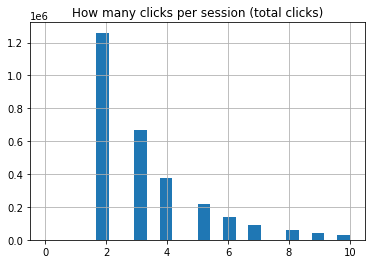

In [12]:
# Plot nbr of clicks per session
clicks.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session (total clicks)')

In [13]:
# Load clicks_reduced
clicks_reduced = pd.read_csv('Data/clicks_reduced.csv')
print('Le jeu de données clicks contient : ' +
      str(clicks_reduced.shape[0]) + ' lignes et ' +
      str(clicks_reduced.shape[1]) + ' colonnes.')
display(clicks_reduced.head())

Le jeu de données clicks contient : 225734 lignes et 12 colonnes.


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [14]:
import json
clicks_reduced_json = clicks_reduced.to_json()
# Directly from dictionary
with open('Data/clicks_reduced.json', 'w') as outfile:
    json.dump(clicks_reduced_json, outfile)

clicks_reduced.to_pickle("Data/clicks_reduced.pickle")  

Text(0.5, 1.0, 'How many clicks per session (reduced clicks)')

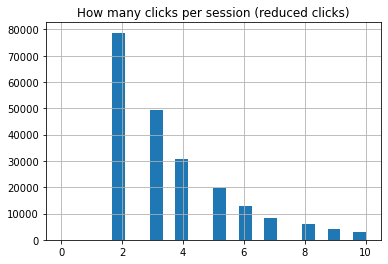

In [15]:
# Plot nbr of clicks per session
clicks_reduced.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session (reduced clicks)')

## 2. Content-base recommander <a class="anchor" id="chapter2"></a>

La recommandation est guider l'utilisateur dans son exploration des données afin qu'il trouve des informations pertinentes. Les systèmes de recommandation ont été étudiés dans des domaines divers et variés comme le web, le e-commerce et bien d'autres. Les trois approches les plus courantes sont celles basées sur le contenu, les approches collaboratives et les approches hybrides (qui sont une combinaison des deux précédentes). Nous abordons ici deux approches pour proposer des recommandations à un utilisateur :
- méthode basée sur le contenu : l'utilisateur se verra recommander des éléments semblables (au sens d'une mesure de similarité entre éléments) à ceux qu'il a préférés dans le passé.
- méthode collaborative ou basée sur le filtrage collaboratif : l'utilisateur se verra recommander des éléments que d’autres utilisateurs ayant des goûts et des préférences similaires (au sens d'une similarité entre utilisateurs et éléments) ont aimé dans le passé. <br/>

Étudions la méthode basée sur le contenu dans cette partie et la méthode collaborative sera traité dans la prochaine partie. 
On utilisera la similarité cosinus  pour la mesure de similarité entre les élements. Mathématiquement, il mesure le cosinus de l'angle entre deux vecteurs projetés dans un espace multidimensionnel. La valeur de sortie est comprise entre 0 et 1. 0 signifie aucune similitude, tandis que 1 signifie que les deux éléments sont similaires à 100 %. 

Cette méthode présente des avantages et des incovénients: <br/>

Les avantages :
+ ils recommandent des éléments similaires à ceux que les utilisateurs ont aimés dans le passé ;
+ ils prennent en compte le profil des utilisateurs, ainsi les recommandations les plus pertinentes pour chacun ;
+ les données relatives aux autres utilisateurs sont inutiles ;
+ il n'y a pas de problème de démarrage à froid lorsqu'un nouvel élément est ajouté au catalogue puisqu'il s'agit de faire coïncider les préférences de l'utilisateur et les caractéristiques des éléments ;
+ il est possible de recommander de nouveaux éléments ou même des éléments qui ne sont pas populaires. 

Les incovénients :
- tous les contenus ne peuvent pas être représentés avec des mots-clés (par exemple, les images) ;
- les utilisateurs ayant visualisé un très grand nombre d'éléments posent un problème (trop d'informations dans le profil de l'utilisateur à faire coïncider avec les caractéristiques des éléments) ;
- lorsqu'un nouvel utilisateur commence à utiliser le système, il n'existe pas d'historique ;
- les profils des utilisateurs restent difficiles à élaborer et, qui plus est, il faut prendre en compte l'évolution des intérêts de l'utilisateur.

In [16]:
def top5(articles_embeddings, userId, clicks_final):
    # get all articles read by user
    var = clicks_final.loc[clicks_final['user_id']==userId]['click_article_id'].tolist()
    
#     #chose randomly one
#     value = randint(0, len(var))
#     print(value)
    
    # chose last one --> le plus proche en terme de préférence
    value = var[-1]
#     print(value)

    # get 5 articles the most similar to the selected one
    distances = distance.cdist([articles_embeddings[value]], articles_embeddings, "cosine")[0]
    
    # find indexes except the one selected
    result = np.argsort(distances)[1:6]
    
    # similarity value between selected article and 5 top proposed articles (the smaller the better!)
    similarite = distance.cdist([articles_embeddings[value]], articles_embeddings[result], "cosine")[0]
    return result, similarite

In [17]:
# Top 5 recommandation
userId = 1 

# avec clicks_tot
top5_0, similarity_0 = top5(articles_embeddings, userId, clicks)
print('Top 5 recommandations et similairté avec clicks : ')
print(top5_0)
print(similarity_0)
print('\n')

# avec clicks_reduced
top5_0_r, similarity_0_r = top5(articles_embeddings, userId, clicks_reduced)
print('Top 5 recommandations et similairté avec clicks_reduced : ')
print(top5_0_r)
print(similarity_0_r)

Top 5 recommandations et similairté avec clicks : 
[236309 229742 234377 233829 231716]
[0.0568937  0.05978188 0.0629848  0.06589322 0.06682673]


Top 5 recommandations et similairté avec clicks_reduced : 
[236309 229742 234377 233829 231716]
[0.0568937  0.05978188 0.0629848  0.06589322 0.06682673]


In [18]:
# Réduction de la taille de la matrice embedding pour faire tourner l'application mobile sur AZURE
# La matrice est trop lourde pour faire tourner l'Azure function en serverless !
articles_embeddings_reduced = articles_embeddings[:,0:50]
print(articles_embeddings.shape)
print(articles_embeddings_reduced.shape)

# avec clicks_reduced
top5_0_r, similarity_0_r = top5(articles_embeddings_reduced, userId, clicks_reduced)
print('Top 5 recommandations et similairté avec clicks_reduced : ')
print(top5_0_r)
print(similarity_0_r)

(364047, 50)
(364047, 50)
Top 5 recommandations et similairté avec clicks_reduced : 
[236309 229742 234377 233829 231716]
[0.0568937  0.05978188 0.0629848  0.06589322 0.06682673]


In [19]:
# Enregistrer la matrice réduite
with open('Data/articles_embeddings_reduced.pickle', 'wb') as file_pi:
    pickle.dump(articles_embeddings_reduced, file_pi)

## 3. Collaborative Filtering <a class="anchor" id="chapter3"></a>

L'idée des approches collaboratives est d'essayer de prédire l'opinion d'un utilisateur sur les différents éléments. La recommandation est basée sur les goûts et avis précédents de l'utilisateur et sur une mesure de similarité avec d'autres utilisateurs. Les principales étapes de cette approche sont :
- de nombreuses préférences d'utilisateurs sont enregistrées ;
- un sous-groupe d'utilisateurs est repéré dont les préférences sont similaires à celles de l'utilisateur qui cherche la recommandation ;
- une moyenne des préférences pour ce groupe est calculée ;
- la fonction de préférence qui en résulte est utilisée pour recommander des éléments à l'utilisateur qui cherche la recommandation.

Les systèmes de recommandation collaboratifs ont comme avantages :
- d'utiliser les scores d'autres utilisateurs pour évaluer l'utilité des éléments ;
- de trouver des utilisateurs ou groupes d'utilisateurs dont les intérêts correspondent à l'utilisateur courant ;
- et plus il y a d'utilisateurs plus il y a de scores : meilleurs sont alors les résultats.

Cependant, de tels systèmes ont aussi des inconvénients :
- trouver des utilisateurs ou groupes d'utilisateurs similaires est difficile ;
- il existe aussi le problème du démarrage à froid (cold-start problem) : lorsqu'un nouvel utilisateur utilise le système, ses préférences ne sont pas connues et lorsqu'un nouvel élément est ajouté au catalogue, personne ne lui a attribué de score ;
- dans les systèmes avec un grand nombre d'éléments et d'utilisateurs, le calcul croît linéairement ; des algorithmes appropriés sont donc nécessaires.

Dans ce script, nous n'approfondissons pas l'évaluation de nos modèles, car ce n'est pas le but de ce projet. Nous allons simplement calculer la précision pour évaluer l'algorithme utilisé avec la librairie "implicit" et le RSME pour évaluer l'algorithme utilisé avec la librairie "surprise".  

### 3.1 Avec la librairie "implicit" <a class="anchor" id="section3_1"></a>

In [20]:
# Préparation des données
n_users = clicks_reduced.user_id.unique().shape[0]
n_articles = clicks_reduced.click_article_id.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_articles))
print('Sparsity: {:4.3f}%'.format(float(clicks_reduced.shape[0]) / float(n_users*n_articles) * 100))

Number of users: 10001
Number of models: 12423
Sparsity: 0.182%


In [21]:
# Create mappings
mid_to_idx = {}
idx_to_mid = {}
for (idx, mid) in enumerate(clicks_reduced.click_article_id.unique().tolist()):
    mid_to_idx[mid] = idx
    idx_to_mid[idx] = mid
    
uid_to_idx = {}
idx_to_uid = {}
for (idx, uid) in enumerate(clicks_reduced.user_id.unique().tolist()):
    uid_to_idx[uid] = idx
    idx_to_uid[idx] = uid

In [22]:
# Create sparse matrix
def map_ids(row, mapper):
    return mapper[row]

I = clicks_reduced.user_id.apply(map_ids, args=[uid_to_idx]).values
J = clicks_reduced.click_article_id.apply(map_ids, args=[mid_to_idx]).values
V = np.ones(I.shape[0])
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

In [23]:
# Create a model ALS
# model = implicit.als.AlternatingLeastSquares(factors=50)
# model.fit(likes)

train, test = train_test_split(likes)

model = AlternatingLeastSquares(factors=128, regularization=20, iterations=15)
model.fit(train)

p = precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=1)
print(p)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12423 [00:00<?, ?it/s]

0.077501566743263


In [24]:
userid = 0
# recommend items for a user
recommendations = model.recommend(userid, likes[userid], N=5)
print(recommendations)

itemid = 0
# find related items
related = model.similar_items(itemid, N=5)
print(related)

[(24, 0.20030378), (1639, 0.19764422), (9261, 0.17413606), (221, 0.1567447), (3541, 0.15016752)]
[(0, 1.0), (2550, 0.9407754), (9477, 0.92881143), (8123, 0.9190468), (5516, 0.91722876)]


### 3.2 Avec la librairie "surprise" <a class="anchor" id="section3_2"></a>

In [25]:
# Importation des librairies
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split, cross_validate
from surprise import SVD, accuracy
from collections import defaultdict

In [26]:
# Préparation des données
dataframe = clicks_reduced.merge(articles_metadata, left_on='click_article_id', right_on='article_id')
dataframe = dataframe[['user_id', 'article_id', 'category_id']]
display(dataframe.head())

,user_id,article_id,category_id
0,0,157541,281
1,20,157541,281
2,44,157541,281
3,45,157541,281
4,76,157541,281


In [27]:
# User rating matrix
series = dataframe.groupby(['user_id', 'category_id']).size()
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns = {0:'rate'}, inplace = True)
display(user_rating_matrix)

,user_id,category_id,rate
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
115351,10000,434,1
115352,10000,435,1
115353,10000,436,1
115354,10000,437,8


In [28]:
# Transformation des données pour surprise
reader = Reader(rating_scale=(1,10))
_x = user_rating_matrix.loc[user_rating_matrix.rate > 1]
data = Dataset.load_from_df(_x[['user_id', 'category_id', 'rate']], reader)

print('We have selects', len(_x), 'interactions.')

We have selects 39216 interactions.


In [29]:
# Train test split
X_train, X_test = train_test_split(data, test_size=0.20)
print('Test set lenght :', len(X_test))
print('Train set lenght :', len(_x) - len(X_test))

Test set lenght : 7844
Train set lenght : 31372


In [30]:
# Création d'un modèle SVD
algo = SVD()
algo.fit(X_train)

In [31]:
# Make prediction on test set
predictions = algo.test(X_test)
print('Number of predictions in Test set :', len(predictions))

Number of predictions in Test set : 7844


In [32]:
# Calcul de RMSE
accuracy.rmse(predictions)

RMSE: 3.7466


3.746575610296258

In [33]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [34]:
# Recommandation 
def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

top_n = get_top_n(predictions, n=5)
findRecom(top_n, 10)

[136, 331]